In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_dpm = pd.read_csv('dpm-opt-experiments.csv')
df_dfm = pd.read_csv('dfm-opt-experiments.csv')
df_custom = pd.read_csv('custom-opt-experiments.csv')

In [3]:
def get_groups(x: str):
    y = x.split('-')[1].split("chain")[-1]
    return ((int(y) - 1) // 10) + 1


df_dpm.insert(0, 'group', df_dpm['name'].apply(get_groups))
df_dfm.insert(0, 'group', df_dfm['name'].apply(get_groups))
df_custom.insert(0, 'group', df_custom['name'].apply(get_groups))

In [4]:
def process_metrics(df_out: pd.DataFrame) -> pd.DataFrame:
    df_out["lb1_ratio"] = df_out["lb1_start"] / df_out["lower_bound"]
    df_out["lb5_ratio"] = df_out["lb5_start"] / df_out["lower_bound"]
    df_out["solved"] = (df_out["incumbent"] - df_out["lower_bound"]) ** 2 <= 1e-3


process_metrics(df_dpm)
process_metrics(df_dfm)
process_metrics(df_custom)

In [24]:
def plot_in_ax(df: pd.DataFrame, name: str, ax: plt.Axes) -> None:
    # Calculate log(1 + nodes)
    df['log_nodes'] = np.log10(1 + df['nodes'])

    # Create boxplot
    df.boxplot(
        column='log_nodes',
        by='group',
        ax=ax,
        color={
            'boxes': 'black',
            'whiskers': 'black',
            'medians': 'green',
            'caps': 'black',
        },
    )
    ax.set_title(None)
    ax.set_xlabel(f'Groups: {name}')
    ax.set_ylabel('$log(1 + N)$')
    ax.set_ylim(-0.25, 8.25)
    ax.set_yticks(range(9))
    ax.get_figure().suptitle('')  # Remove default title

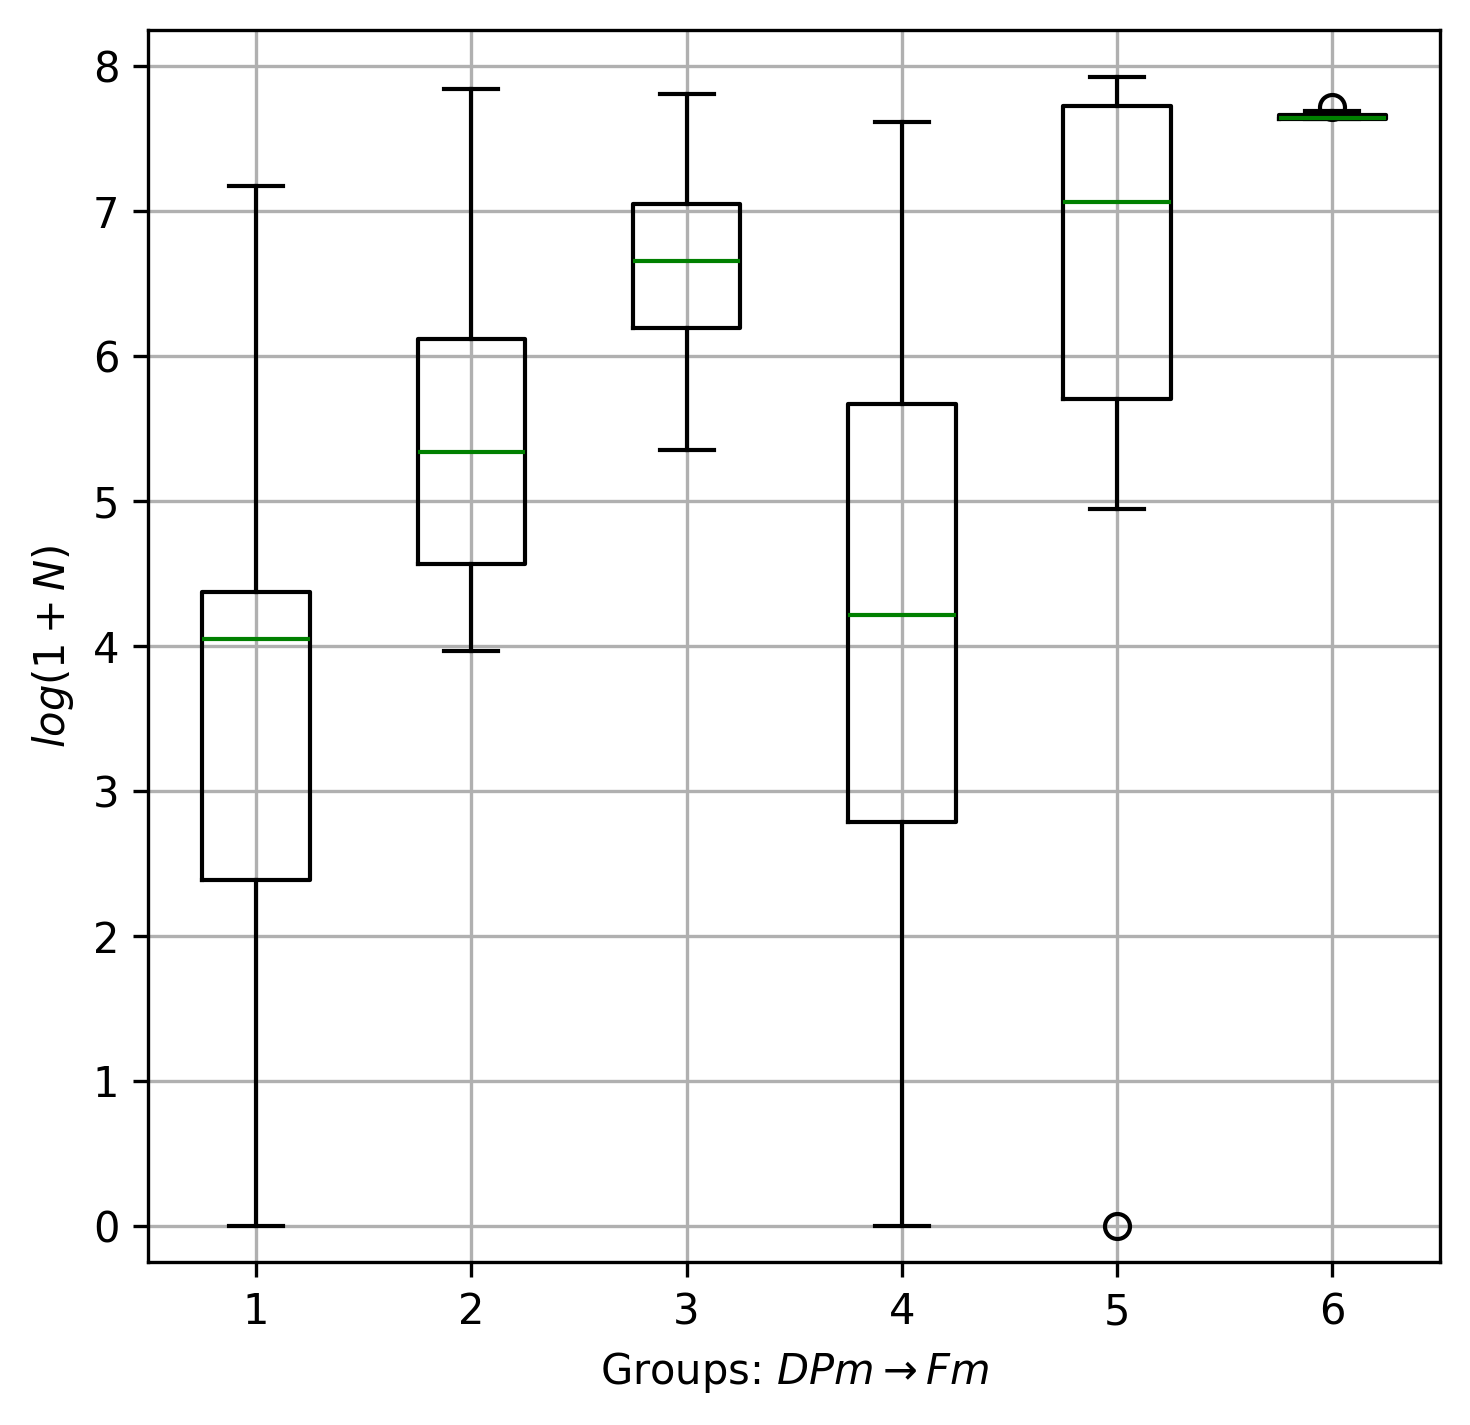

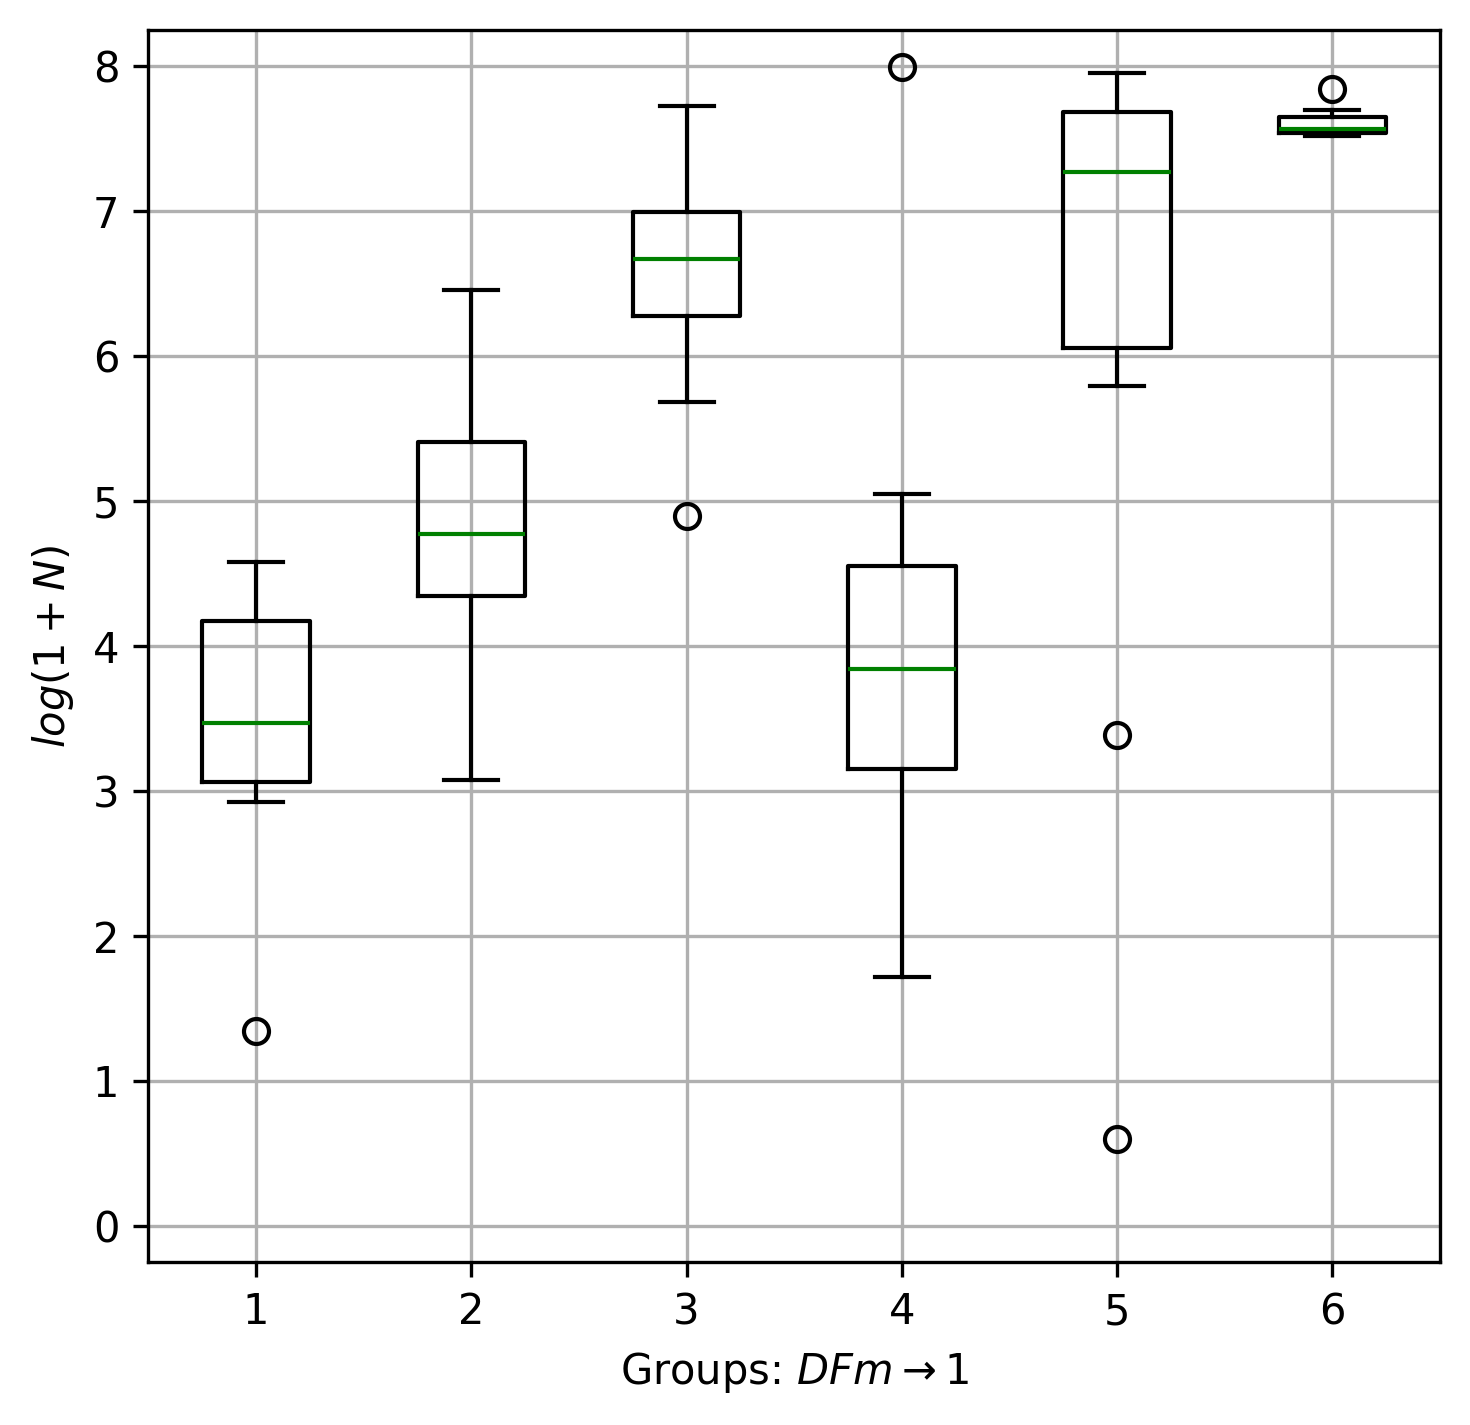

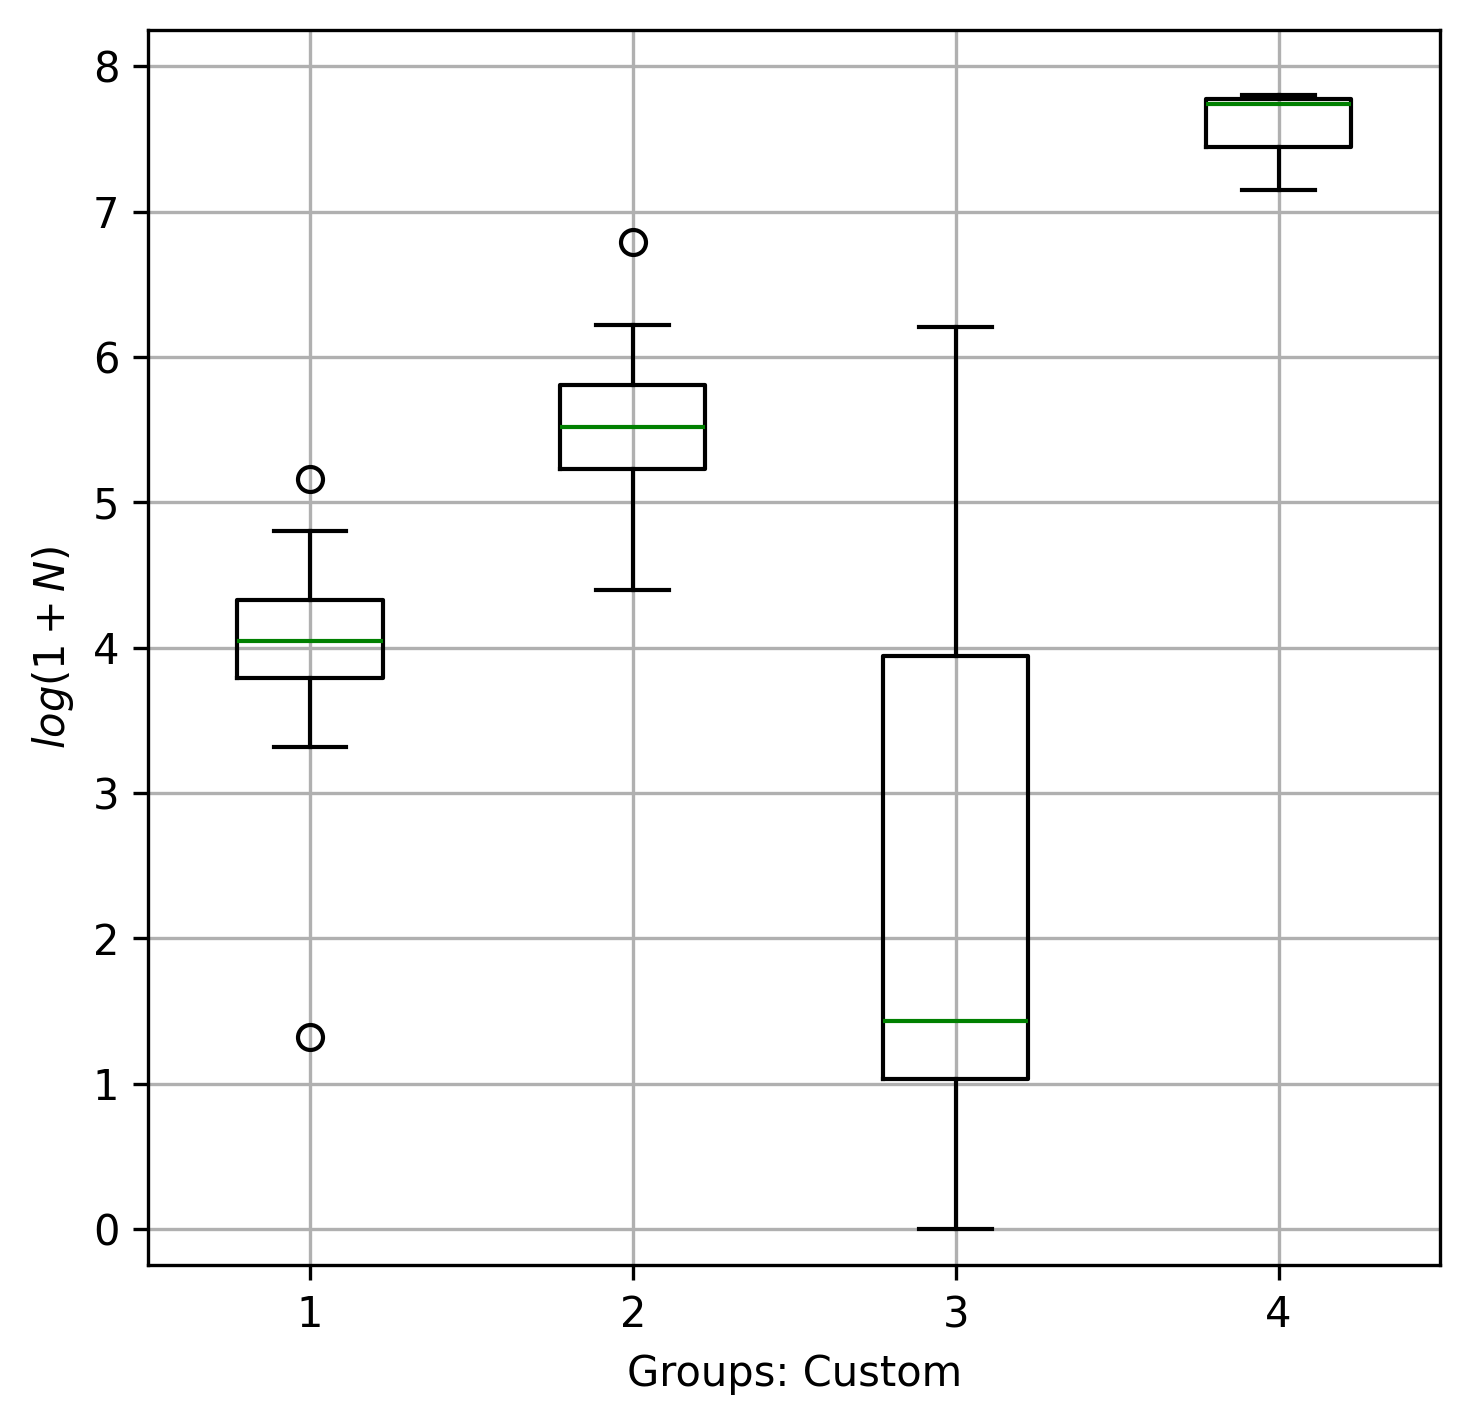

In [27]:
# Create figure
# Plot for each dataset
for df, name, filename in [
    (df_dpm, r'$DPm \rightarrow Fm$', "dpm"),
    (df_dfm, r'$DFm \rightarrow 1$', "dfm"),
    (df_custom, 'Custom', "custom"),
]:

    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
    # Calculate log(1 + nodes)
    plot_in_ax(df, name, ax)

    plt.tight_layout()
    plt.savefig(f"boxplot-{filename}-nodes.pdf")

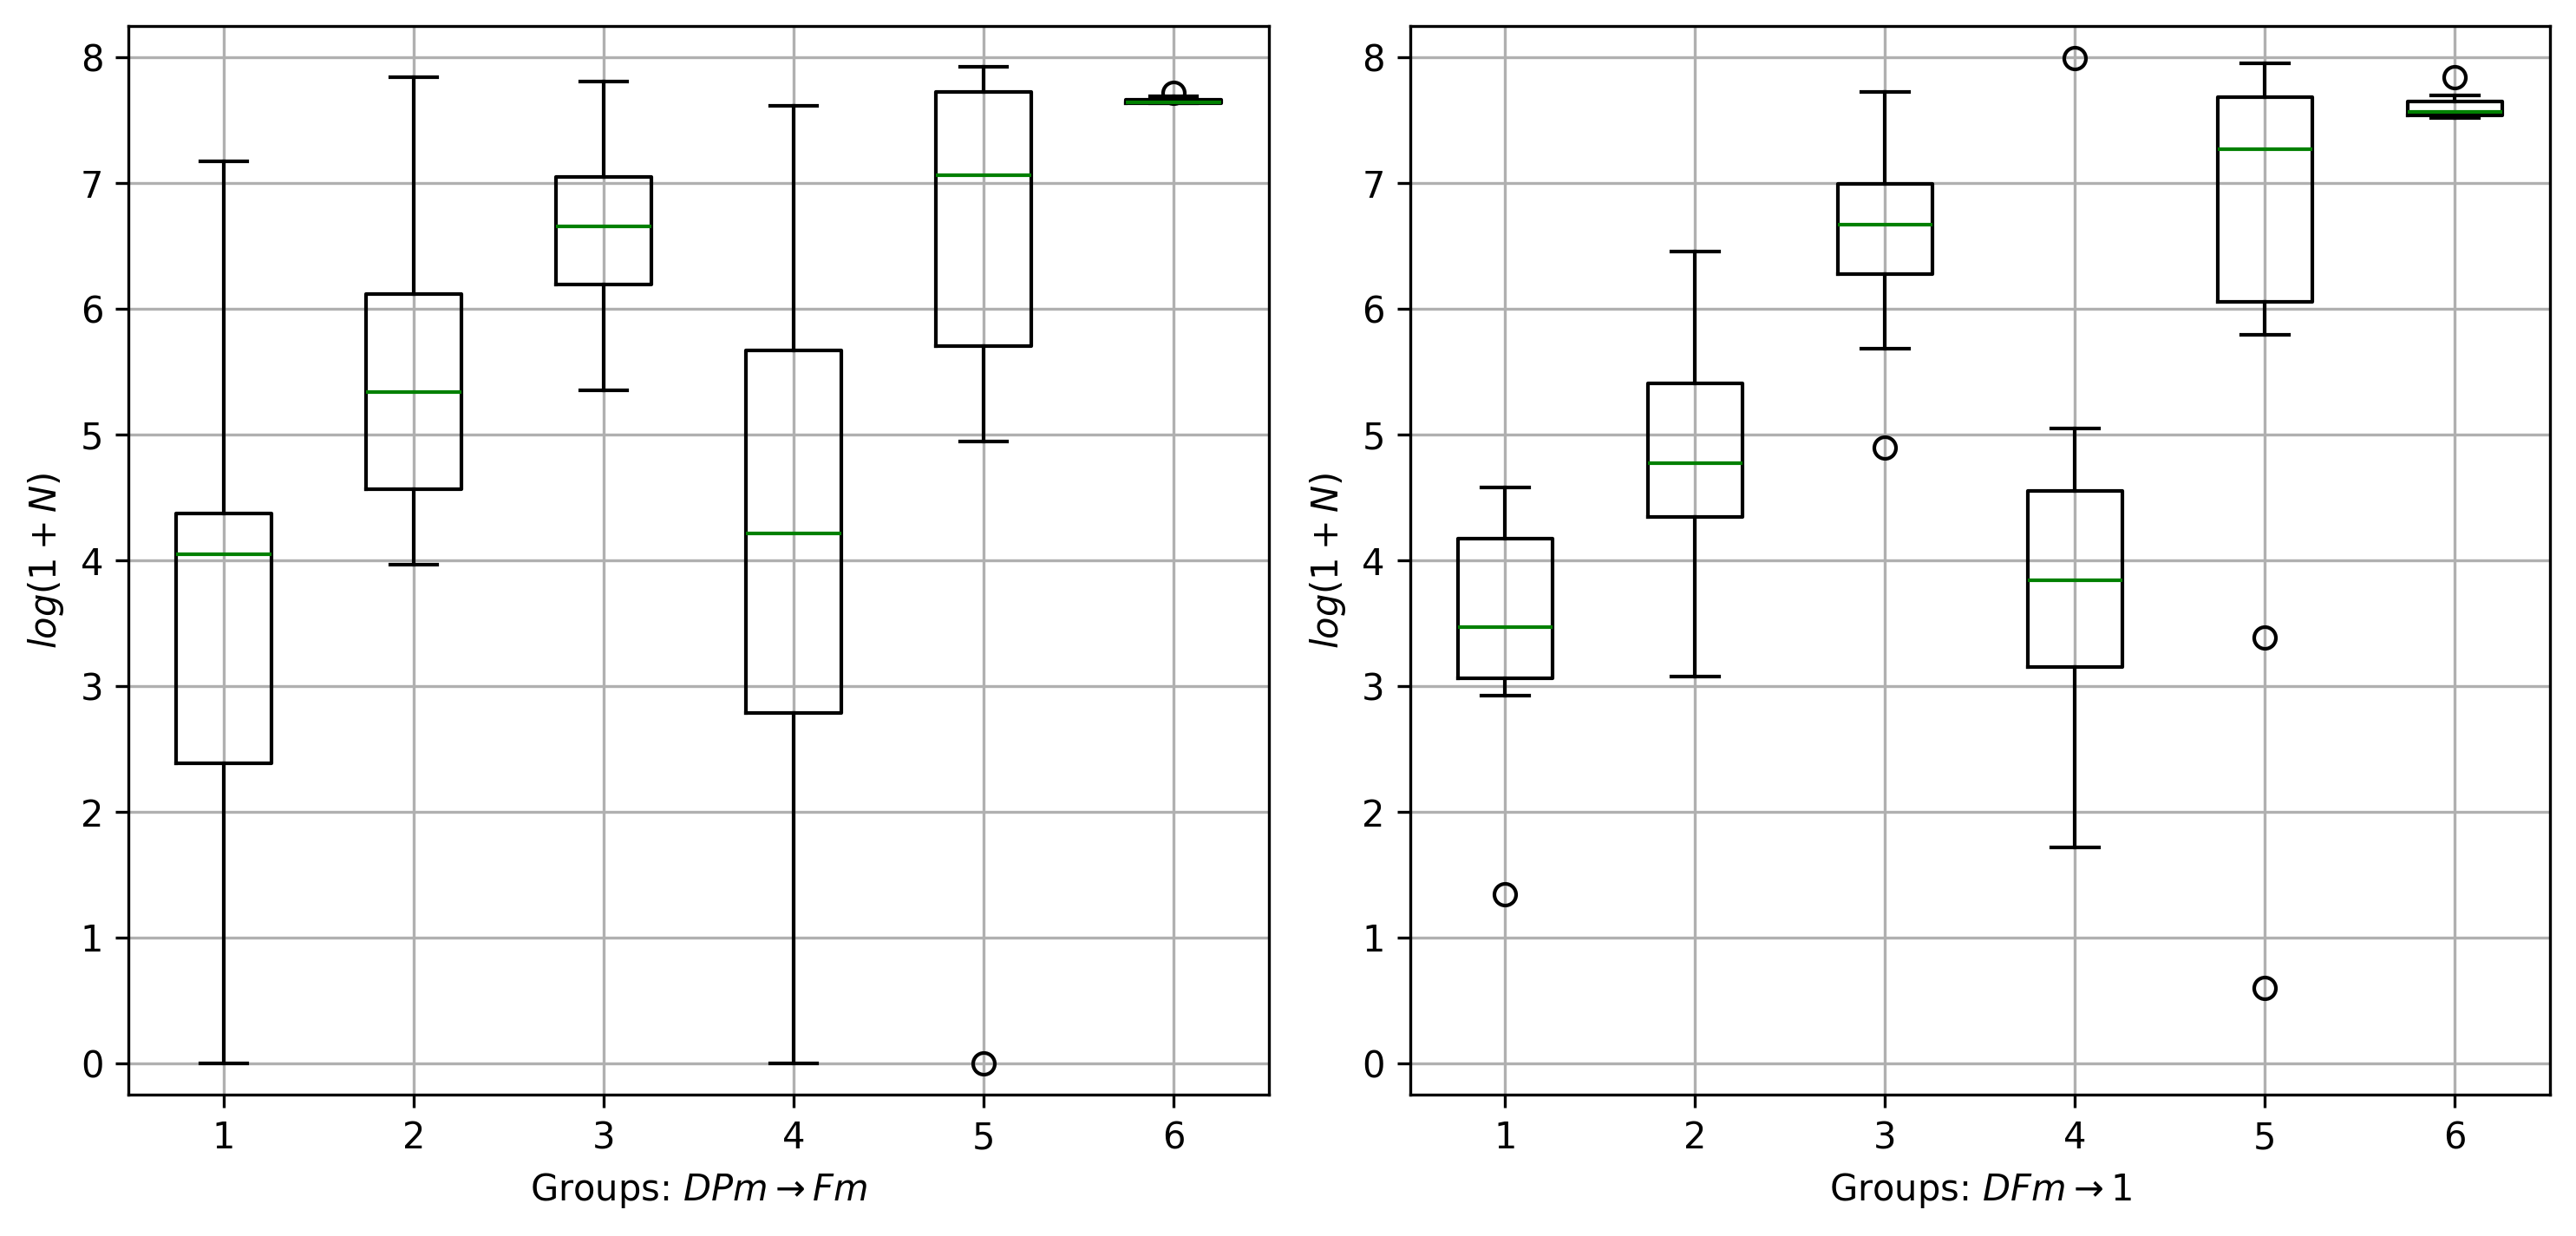

In [26]:
# Create figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

# Plot for each dataset
for ax, (df, name) in zip(
    axes,
    [
        (df_dpm, r'$DPm \rightarrow Fm$'),
        (df_dfm, r'$DFm \rightarrow 1$'),
        # (df_custom, 'Custom'),
    ],
):
    # Calculate log(1 + nodes)
    plot_in_ax(df, name, ax)

plt.tight_layout()
plt.show()

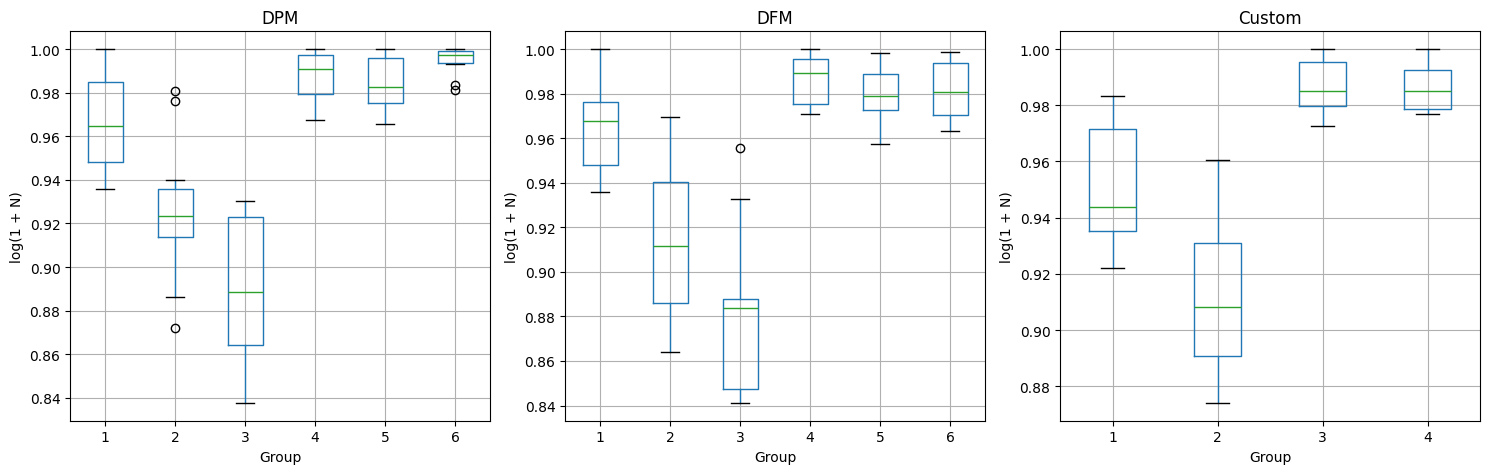

In [11]:
# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for each dataset
for ax, (df, name) in zip(
    axes, [(df_dpm, 'DPM'), (df_dfm, 'DFM'), (df_custom, 'Custom')]
):
    # Calculate log(1 + nodes)
    df['log_nodes'] = np.log10(1 + df['nodes'])

    # Create boxplot
    df.boxplot(column='lb1_ratio', by='group', ax=ax)
    ax.set_xlabel('Group')
    ax.set_ylabel('log(1 + N)')
    ax.set_title(name)
    ax.get_figure().suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

In [15]:
def agg_dataframe(df_out: pd.DataFrame) -> pd.DataFrame:
    result = df_out.groupby('group', as_index=False).agg({
        'lb1_ratio': 'mean',
        'lb5_ratio': 'mean',
        'gap': 'mean',
        'execution_time': 'median',
        'nodes': 'median',
        'solved': 'sum',
    }).rename(columns={'Instance': 'Instances'})

    # Round lb ratios to 3 decimals
    result['lb1_ratio'] = result['lb1_ratio'].round(3)
    result['lb5_ratio'] = result['lb5_ratio'].round(3)

    # Convert gap to percentage
    result['gap'] = (result['gap'] * 100).round(2)

    # Round execution time to 4 significant digits
    result['execution_time'] = result['execution_time'].apply(
        lambda x: float(f"{x:.2g}")
    )

    # Format nodes in scientific notation with 2 significant digits
    result['nodes'] = result['nodes'].apply(
        lambda x: f"{x:.2g}"
    )

    # Insert group info
    if result.shape[0] == 6:
        result.insert(1, "n", [20, 20, 20, 50, 50, 50])
        result.insert(2, "m", [7, 10, 15, 7, 10, 15])
    else:
        result.insert(1, "n", [20, 20, 50, 50])
        result.insert(2, "m", [7, 10, 7, 10])

    return result

In [16]:
agg_dataframe(df_dfm)

,group,n,m,lb1_ratio,lb5_ratio,gap,execution_time,nodes,solved
0,1,20,7,0.964,0.970,0.00,0.055,2.9e+03,10
1,2,20,10,0.915,0.923,0.00,1.800,6e+04,10
2,3,20,15,0.882,0.908,0.73,260.000,5e+06,9
3,4,50,7,0.986,0.987,0.06,0.340,7.2e+03,9
4,5,50,10,0.980,0.983,0.59,790.000,1.9e+07,8
5,6,50,15,0.982,0.984,5.72,3600.000,3.7e+07,0


In [17]:
agg_dataframe(df_dpm)

,group,n,m,lb1_ratio,lb5_ratio,gap,execution_time,nodes,solved
0,1,20,7,0.966,0.971,0.00,0.18,1.2e+04,10
1,2,20,10,0.926,0.942,0.00,5.00,2.2e+05,10
2,3,20,15,0.889,0.920,0.76,230.00,4.5e+06,9
3,4,50,7,0.988,0.991,0.00,0.74,3e+04,10
4,5,50,10,0.984,0.989,0.30,510.00,1.3e+07,8
5,6,50,15,0.994,1.004,5.47,3600.00,4.4e+07,0


In [18]:
agg_dataframe(df_custom)

,group,n,m,lb1_ratio,lb5_ratio,gap,execution_time,nodes,solved
0,1,20,7,0.951,0.959,0.00,0.2,1.1e+04,10
1,2,20,10,0.912,0.923,0.00,16.0,3.8e+05,10
2,3,50,7,0.987,0.989,0.00,3.7,32,10
3,4,50,10,0.986,0.988,1.65,3600.0,5.5e+07,4


In [8]:
agg_dataframe(df_dpm).to_csv("dpm-opt-summary.csv", index=False)

In [9]:
agg_dataframe(df_dfm).to_csv("dfm-opt-summary.csv", index=False)

In [19]:
agg_dataframe(df_custom).to_csv("custom-opt-summary.csv", index=False)

In [12]:
df_dpm.head()

,group,name,warmstart,lb1_start,lb5_start,incumbent,lower_bound,execution_time,gap,nodes,sequence,Group
0,1,dpm-001-20-5x6,1465,1326,1326,1381,1381,0.288417,0.0,12255,"[17, 10, 15, 2, 16, 19, 6, 18, 14, 12, 9, 5, 1...",1
1,1,dpm-002-20-5x6,1455,1328,1328,1385,1385,0.160825,0.0,9840,"[6, 3, 14, 8, 19, 0, 16, 1, 7, 11, 9, 5, 12, 4...",1
2,1,dpm-003-20-5x6,1559,1470,1470,1485,1485,0.011168,0.0,77,"[1, 16, 6, 7, 11, 17, 12, 3, 2, 14, 8, 4, 0, 1...",1
3,1,dpm-004-20-5x6,1519,1413,1413,1458,1458,0.121580,0.0,7669,"[9, 19, 12, 10, 2, 0, 15, 18, 4, 5, 7, 8, 3, 6...",1
4,1,dpm-005-20-5x6,1511,1371,1382,1465,1465,402.908985,0.0,21733552,"[0, 1, 2, 8, 12, 4, 16, 9, 10, 14, 15, 19, 13,...",1
